<a href="https://colab.research.google.com/github/Stephanie9606/MultimodalDeepLearning_OnlineMemeClassification/blob/main/binary_mulitimodal_early_fusion_memes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, LSTM

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2, l1

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import re
import glob
import os
import cv2
import sys
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from tensorflow.keras.utils import plot_model

In [ ]:
# Set up the device for GPU usage
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# connect to google drive for files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-processing

In [ ]:
# unzip image file
!unzip /content/drive/MyDrive/memes_image.zip

Streaming output truncated to the last 5000 lines.
  inflating: memes_image/27q56q.jpg  
  inflating: memes_image/2jbfb0.jpg  
  inflating: memes_image/cokzi.jpg   
  inflating: memes_image/3evo55.jpg  
  inflating: memes_image/3j9ip4.jpg  
  inflating: memes_image/37grpj.jpg  
  inflating: memes_image/16ecag.jpg  
  inflating: memes_image/3amkes.jpg  
  inflating: memes_image/2it5fg.jpg  
  inflating: memes_image/3ib0a5.jpg  
  inflating: memes_image/1nxss5.jpg  
  inflating: memes_image/2xe9ec.jpg  
  inflating: memes_image/3x4mqb.jpg  
  inflating: memes_image/2l1hby.jpg  
  inflating: memes_image/2h2iub.jpg  
  inflating: memes_image/3aq9fw.jpg  
  inflating: memes_image/3buxz8.jpg  
  inflating: memes_image/2zo1rp.jpg  
  inflating: memes_image/30zc8e.jpg  
  inflating: memes_image/10ymwz.jpg  
  inflating: memes_image/252pwu.jpg  
  inflating: memes_image/322kp8.jpg  
  inflating: memes_image/3awmha.jpg  
  inflating: memes_image/205ata.jpg  
  inflating: memes_image/eutr9.jpg   

In [ ]:
memesDF = pd.read_csv('/content/drive/MyDrive/top5_memes_tidy.tsv', sep='\t')

In [ ]:
memesDF = memesDF.iloc[:, 2:9]

In [ ]:
memesDF['AltText'] = memesDF['AltText'].astype(pd.StringDtype())
memesDF['MemeLabel'] = memesDF['MemeLabel'].astype(pd.StringDtype())
memesDF['CaptionText'] = memesDF['CaptionText'].astype(pd.StringDtype())
memesDF['HashId'] = memesDF['HashId'].astype(pd.StringDtype())
memesDF['ImageURL'] = memesDF['ImageURL'].astype(pd.StringDtype())
memesDF['ImagePath'] = memesDF['ImagePath'].astype(pd.StringDtype())
memesDF['Image'] = memesDF['Image'].astype(pd.StringDtype())

In [ ]:
# Only get two label for Binary Classification
meme2cDF = memesDF[(memesDF['MemeLabel'] == "Scared Cat") | (memesDF['MemeLabel'] == "Who Killed Hannibal")]

In [ ]:
meme2cDF.head(3)

,AltText,CaptionText,ImageURL,HashId,MemeLabel,ImagePath,Image
0,Coke in Regal Cinemas > Pepsi in Regal Cinemas...,WHO WANTS A PEPSI?,http://i.imgflip.com/3xa87f.jpg,b54073fe552aa582c57a1a39e9db3f550067775516b844...,Who Killed Hannibal,/content/memes_image/3xa87f.jpg,3xa87f.jpg
1,Who Killed Hannibal | NORTH KOREA PEOPLE WITH ...,NORTH KOREA PEOPLE WITH CORONAVIRUS WE HAVE 0...,http://i.imgflip.com/3v9nm3.jpg,55a37d7aac7c769f4d517ea20b50c8ffa8e545491e45c1...,Who Killed Hannibal,/content/memes_image/3v9nm3.jpg,3v9nm3.jpg
2,Who Killed Hannibal | MINECRAFT CAVE UPDATE MI...,MINECRAFT CAVE UPDATE MINECRAFT,http://i.imgflip.com/3xjml3.jpg,ba01cf5a250ad0d9dc2901c5250ddf0e49abc8fb8e0a80...,Who Killed Hannibal,/content/memes_image/3xjml3.jpg,3xjml3.jpg


In [ ]:
# train test split
from sklearn.model_selection import train_test_split

me_trainDF, me_testDF = train_test_split(meme2cDF, test_size=0.25, random_state=15)

In [ ]:
me_trainDF, me_valDF = train_test_split(me_trainDF, test_size=0.25, random_state=13)

In [ ]:
n1 = me_trainDF.index
n2 = me_valDF.index
n3 = me_testDF.index
print(n1)
print(n2)
print(n3)

Index([ 499,  340, 2383, 3287,  716, 1176,  509,  762,  953,  168,
       ...
       2397, 2845, 2677, 3352,  542, 3218, 2606,  336,  177, 2711],
      dtype='int64', length=1308)
Index([2289, 3195, 2359, 2478,  834, 2530,  641, 3249,  204,  996,
       ...
       3006, 2699,  586,  140, 1017, 1020,  722, 3372, 2686,   49],
      dtype='int64', length=437)
Index([2944, 3167, 2649,  164, 2661, 2822, 1158, 3348,  484,  721,
       ...
       2717,  896,  159,  200,  150,  573, 2854, 2993,  292,  423],
      dtype='int64', length=582)


In [ ]:
me_trainDF = me_trainDF.iloc[0:1280,:]
me_valDF = me_valDF.iloc[0:416,:]
me_testDF = me_testDF.iloc[0:576,:]

In [ ]:
#check for distribution
import pandas as pd

train_counts = me_trainDF['MemeLabel'].value_counts()
val_counts = me_valDF['MemeLabel'].value_counts()
test_counts = me_testDF['MemeLabel'].value_counts()

#combine
combined_counts = pd.concat([train_counts, val_counts, test_counts], axis=1)
combined_counts.columns = ['train_counts', 'val_counts', 'test_counts']

#calculate the total counts for each column
total_train_count = combined_counts['train_counts'].sum()
total_val_count = combined_counts['val_counts'].sum()
total_test_count = combined_counts['test_counts'].sum()

#calculate ratios by each column and add them as new columns
combined_counts['train_Ratio'] = round(combined_counts['train_counts'] / total_train_count, 2)
combined_counts['val_Ratio'] = round(combined_counts['val_counts'] / total_val_count, 2)
combined_counts['test_Ratio'] = round(combined_counts['test_counts'] / total_test_count, 2)

combined_counts.columns = ['train_counts', 'val_counts', 'test_counts', 'train_Ratio', 'val_Ratio', 'test_Ratio']

print(combined_counts.iloc[:,3:])

                     train_Ratio  val_Ratio  test_Ratio
MemeLabel                                              
Who Killed Hannibal         0.52       0.52        0.51
Scared Cat                  0.48       0.48        0.49


# Image Pre-processing

In [ ]:
 # Loading training data
img_height = 224
img_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.)
val_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.)
train_generator = train_datagen.flow_from_dataframe(dataframe=me_trainDF,
                                                    directory=None,
                                                    x_col="ImagePath",
                                                    y_col="MemeLabel",
                                                    class_mode="binary",
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=False)

valid_generator = val_datagen.flow_from_dataframe(dataframe=me_valDF,
                                                    directory=None,
                                                    x_col="ImagePath",
                                                    y_col="MemeLabel",
                                                    class_mode="binary",
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=False)

print(f"Class labels: {train_generator.class_indices}")
print(f"Class labels: {valid_generator.class_indices}")

#step_size = train_generator.n//train_generator.batch_size

Found 1280 validated image filenames belonging to 2 classes.
Found 416 validated image filenames belonging to 2 classes.
Class labels: {'Scared Cat': 0, 'Who Killed Hannibal': 1}
Class labels: {'Scared Cat': 0, 'Who Killed Hannibal': 1}


In [ ]:
images, labels = next(train_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 224, 224, 3)
float32 (32,)


In [ ]:
# convert generator to tf.dataset: image_train_data, image_val_data
image_train_data = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([32,224,224,3], [32,]) # based on batch_size change
)

image_val_data = tf.data.Dataset.from_generator(
    lambda: valid_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([32,224,224,3], [32,])
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [ ]:
# check data's structure
image_train_data.element_spec
image_val_data.element_spec

(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

In [ ]:
# image train, val batch drop remainder
#image_train_data = image_train_data.unbatch()
#image_train_data = image_train_data.batch(32, drop_remainder=True)

#image_val_data = image_val_data.unbatch()
#image_val_data = image_val_data.batch(32, drop_remainder=True)

#image_train_data.element_spec
#image_val_data.element_spec

In [ ]:
# Loading testing data
test_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.)
batch_size = 32

test_generator = test_datagen.flow_from_dataframe(dataframe=me_testDF,
                                                  directory=None,
                                                  x_col="ImagePath",
                                                  y_col="MemeLabel",
                                                  class_mode="binary",
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False)

print(f"Class labels: {test_generator.class_indices}")

Found 582 validated image filenames belonging to 2 classes.
Class labels: {'Scared Cat': 0, 'Who Killed Hannibal': 1}


In [ ]:
images, labels = next(test_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 224, 224, 3)
float32 (32,)


In [ ]:
# convert generator to tf.dataset: image_test_data
image_test_data = tf.data.Dataset.from_generator(
    lambda: valid_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([32,224,224,3], [32,])
)

In [ ]:
image_test_data.element_spec

(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

In [ ]:
# image test batch drop remainder
image_test_data = image_test_data.unbatch()
image_test_data = image_test_data.batch(32, drop_remainder=True)

image_test_data.element_spec

(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

# Text Pre-processing for BERT

BERT: [CLS] + text + [SEP]

In [ ]:
!pip install -q transformers

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [ ]:
!pip install bert-for-tf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
#!pip3 install tensorflow_hub

#import tensorflow_hub as hub
#import tensorflow as tf
#from tensorflow.keras.models import Model
#import bert

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# convert_data_to_examples: accept train and test datasets and convert each row into an InputExample object.
def convert_data_to_examples(train, val, test, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  test_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return train_InputExamples, validation_InputExamples, test_InputExamples

  train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(me_trainDF,
                                                                                               me_valDF,
                                                                                               me_testDF,
                                                                                              'CaptionText',
                                                                                              'MemeLabel')

In [ ]:
# convert_examples_to_tf_dataset: tokenize the InputExample objects, then create the required input format with the tokenized objects
# finally, create an input dataset that we can feed to the model.
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length", # pad_to_max_length=True
            truncation=True
        )

        #print(len(input_dict))

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )
    def gen():
        for f in features:
            yield (
                  f.input_ids,
                  f.attention_mask,
                  f.token_type_ids
                ,
                # f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        (tf.int32, tf.int32, tf.int32),
        (
              tf.TensorShape([128]),
              tf.TensorShape([128]),
              tf.TensorShape([128])
            ,
            # tf.TensorShape([]),
        ),
    )

DATA_COLUMN = 'CaptionText'
LABEL_COLUMN = 'MemeLabel'

In [ ]:
# call above function
train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(me_trainDF, me_valDF, me_testDF, DATA_COLUMN, LABEL_COLUMN)

text_train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
text_train_data = text_train_data.batch(32, drop_remainder=True)

text_val_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
text_val_data = text_val_data.batch(32, drop_remainder=True)

text_test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
text_test_data = text_test_data.batch(32, drop_remainder=True)

In [ ]:
text_train_data.element_spec

(TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None))

In [ ]:
elem = next(iter(text_train_data))
elem

(<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 2033, 8598, ...,    0,    0,    0],
        [ 101, 2084, 2891, ...,    0,    0,    0],
        [ 101, 2821, 2053, ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2017, ...,    0,    0,    0],
        [ 101, 6307, 2703, ...,    0,    0,    0],
        [ 101, 2043, 2017, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>)

# Merge image and text tf.dataset

In [ ]:
text_train_data.element_spec

(TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None))

In [ ]:
# merged train data
try_data = tf.data.Dataset.zip((image_train_data, text_train_data))
try_data.element_spec
train_data = try_data.map(lambda x, y: ((x[0], y[0], y[1], y[2]), x[1]))
train_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

In [ ]:
# merged validation data
try_data1 = tf.data.Dataset.zip((image_val_data, text_val_data))
try_data1.element_spec
val_data = try_data1.map(lambda x, y: ((x[0], y[0], y[1], y[2]), x[1]))
val_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

In [ ]:
# merged validation data
try_data2 = tf.data.Dataset.zip((image_test_data, text_test_data))
try_data2.element_spec
test_data = try_data2.map(lambda x, y: ((x[0], y[0], y[1], y[2]), x[1]))
test_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

# Early Fusion: load pre-trained model + build multi-model

***--- Image Model ---***

In [ ]:
# Load original model with pretrained weights from imagenet
base_model = applications.VGG16(weights="imagenet")

# Freeze base model
base_model.trainable = False

# Create new model (deeper) on top
img_height = 224
img_width = 224
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
outputs = Dense(128)(x)  # no activation function here for early fusion

vgg16_model = Model(inputs, outputs)
vgg16_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 1000)                │     138,357,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         128,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,485,672 (528.28 MB)

 Trainable params: 128,128 (500.50 KB)

 Non-trainable params: 138,357,544 (527.79 MB)

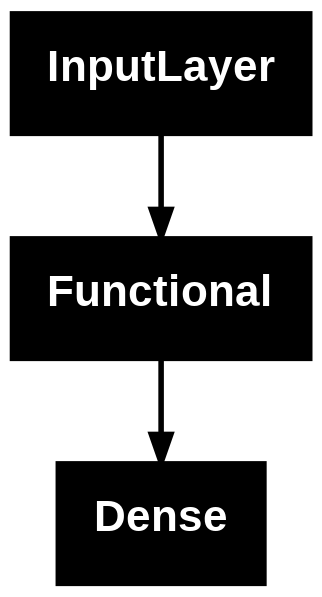

In [ ]:
plot_model(vgg16_model)

***--- Text Model ---***

In [ ]:
#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
#                            trainable=True)

In [ ]:
!pip3 install keras_nlp
import tensorflow as tf
from tensorflow.keras import layers, Model
import keras_nlp

# Define max length and inputs
max_length = 128
input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")

# Load the BERT backbone model from keras_nlp
bert_backbone = keras_nlp.models.BertBackbone.from_preset(
    "hf://bert-base-uncased",
    trainable=True,
)


# Pass the inputs into BERT, including segment_ids as token_type_ids
bert_outputs = bert_backbone({
    "token_ids": input_word_ids,
    "padding_mask": input_mask,
    "segment_ids": segment_ids  # Use segment_ids as token_type_ids
})

# Retrieve the sequence output for LSTM layer
sequence_output = bert_outputs["sequence_output"]
lstm_out = layers.Bidirectional(layers.LSTM(64, name="LSTM"))(sequence_output)

# Build the model
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=lstm_out)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
#pooled_output.shape

In [ ]:
# Keep the Bert layers trainable
for layer in bert_model.layers:
    layer.trainable = True

In [ ]:
bert_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_mask (InputLayer)   │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_word_ids            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 768), (None,   │    109,482,240 │ input_mask[0][0],      │
│ (BertBackbone)            │ 128, 768)]             │                │ segment_ids[0][0],     │
│                           │                        │                │ input_word_ids[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │        426,496 │ bert_backbone[0][1]    │
│ (Bidirectional)           │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 109,908,736 (419.27 MB)

 Trainable params: 109,908,736 (419.27 MB)

 Non-trainable params: 0 (0.00 B)

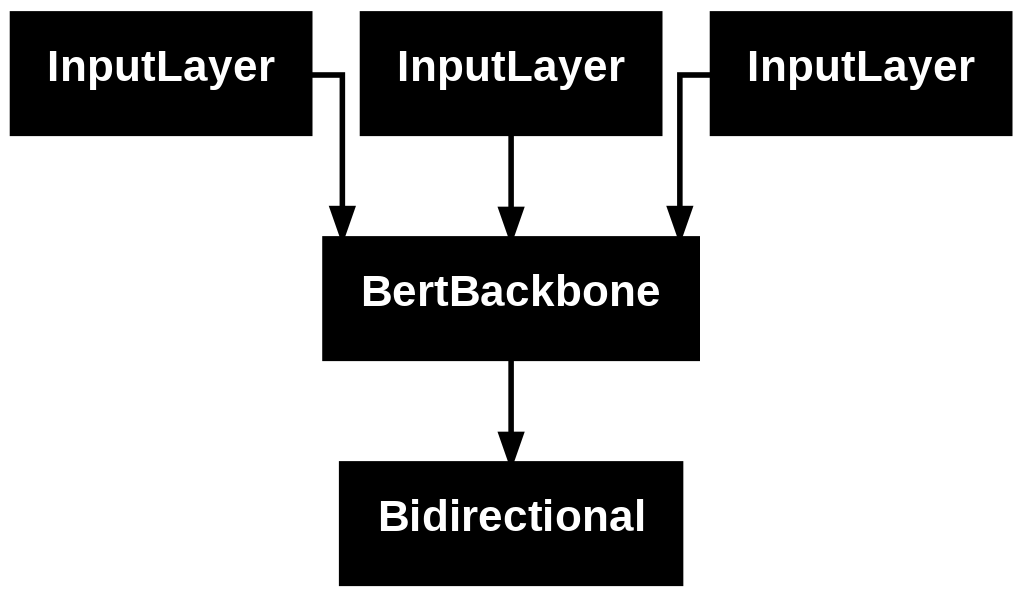

In [ ]:
plot_model(bert_model)

***--- Multimodal ---***

In [ ]:
# Stacking early-fusion multimodal model
#nClasses = 2 # for multi-class

input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_mask")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="segment_ids")
image_input = layers.Input(shape=(img_height, img_width, 3), dtype=tf.float32,
                                       name="image")

image_side = vgg16_model(image_input)
text_side = bert_model([input_word_ids, input_mask, segment_ids])
# Concatenate features from images and texts
merged = layers.Concatenate()([image_side, text_side])
merged = layers.Dense(256, activation = 'relu')(merged)
output = layers.Dense(1, activation='sigmoid', name = "class")(merged)

merge_model = models.Model([image_input, input_word_ids, input_mask, segment_ids], output)

In [ ]:
merge_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_word_ids            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_mask (InputLayer)   │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 128)            │    138,485,672 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 128)            │    109,908,736 │ input_word_ids[0][0],  │
│                           │                        │                │ input_mask[0][0],      │
│                           │                        │                │ segment_ids[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ functional[0][0],      │
│                           │                        │                │ functional_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 1)              │            257 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 248,460,457 (947.80 MB)

 Trainable params: 110,102,913 (420.01 MB)

 Non-trainable params: 138,357,544 (527.79 MB)

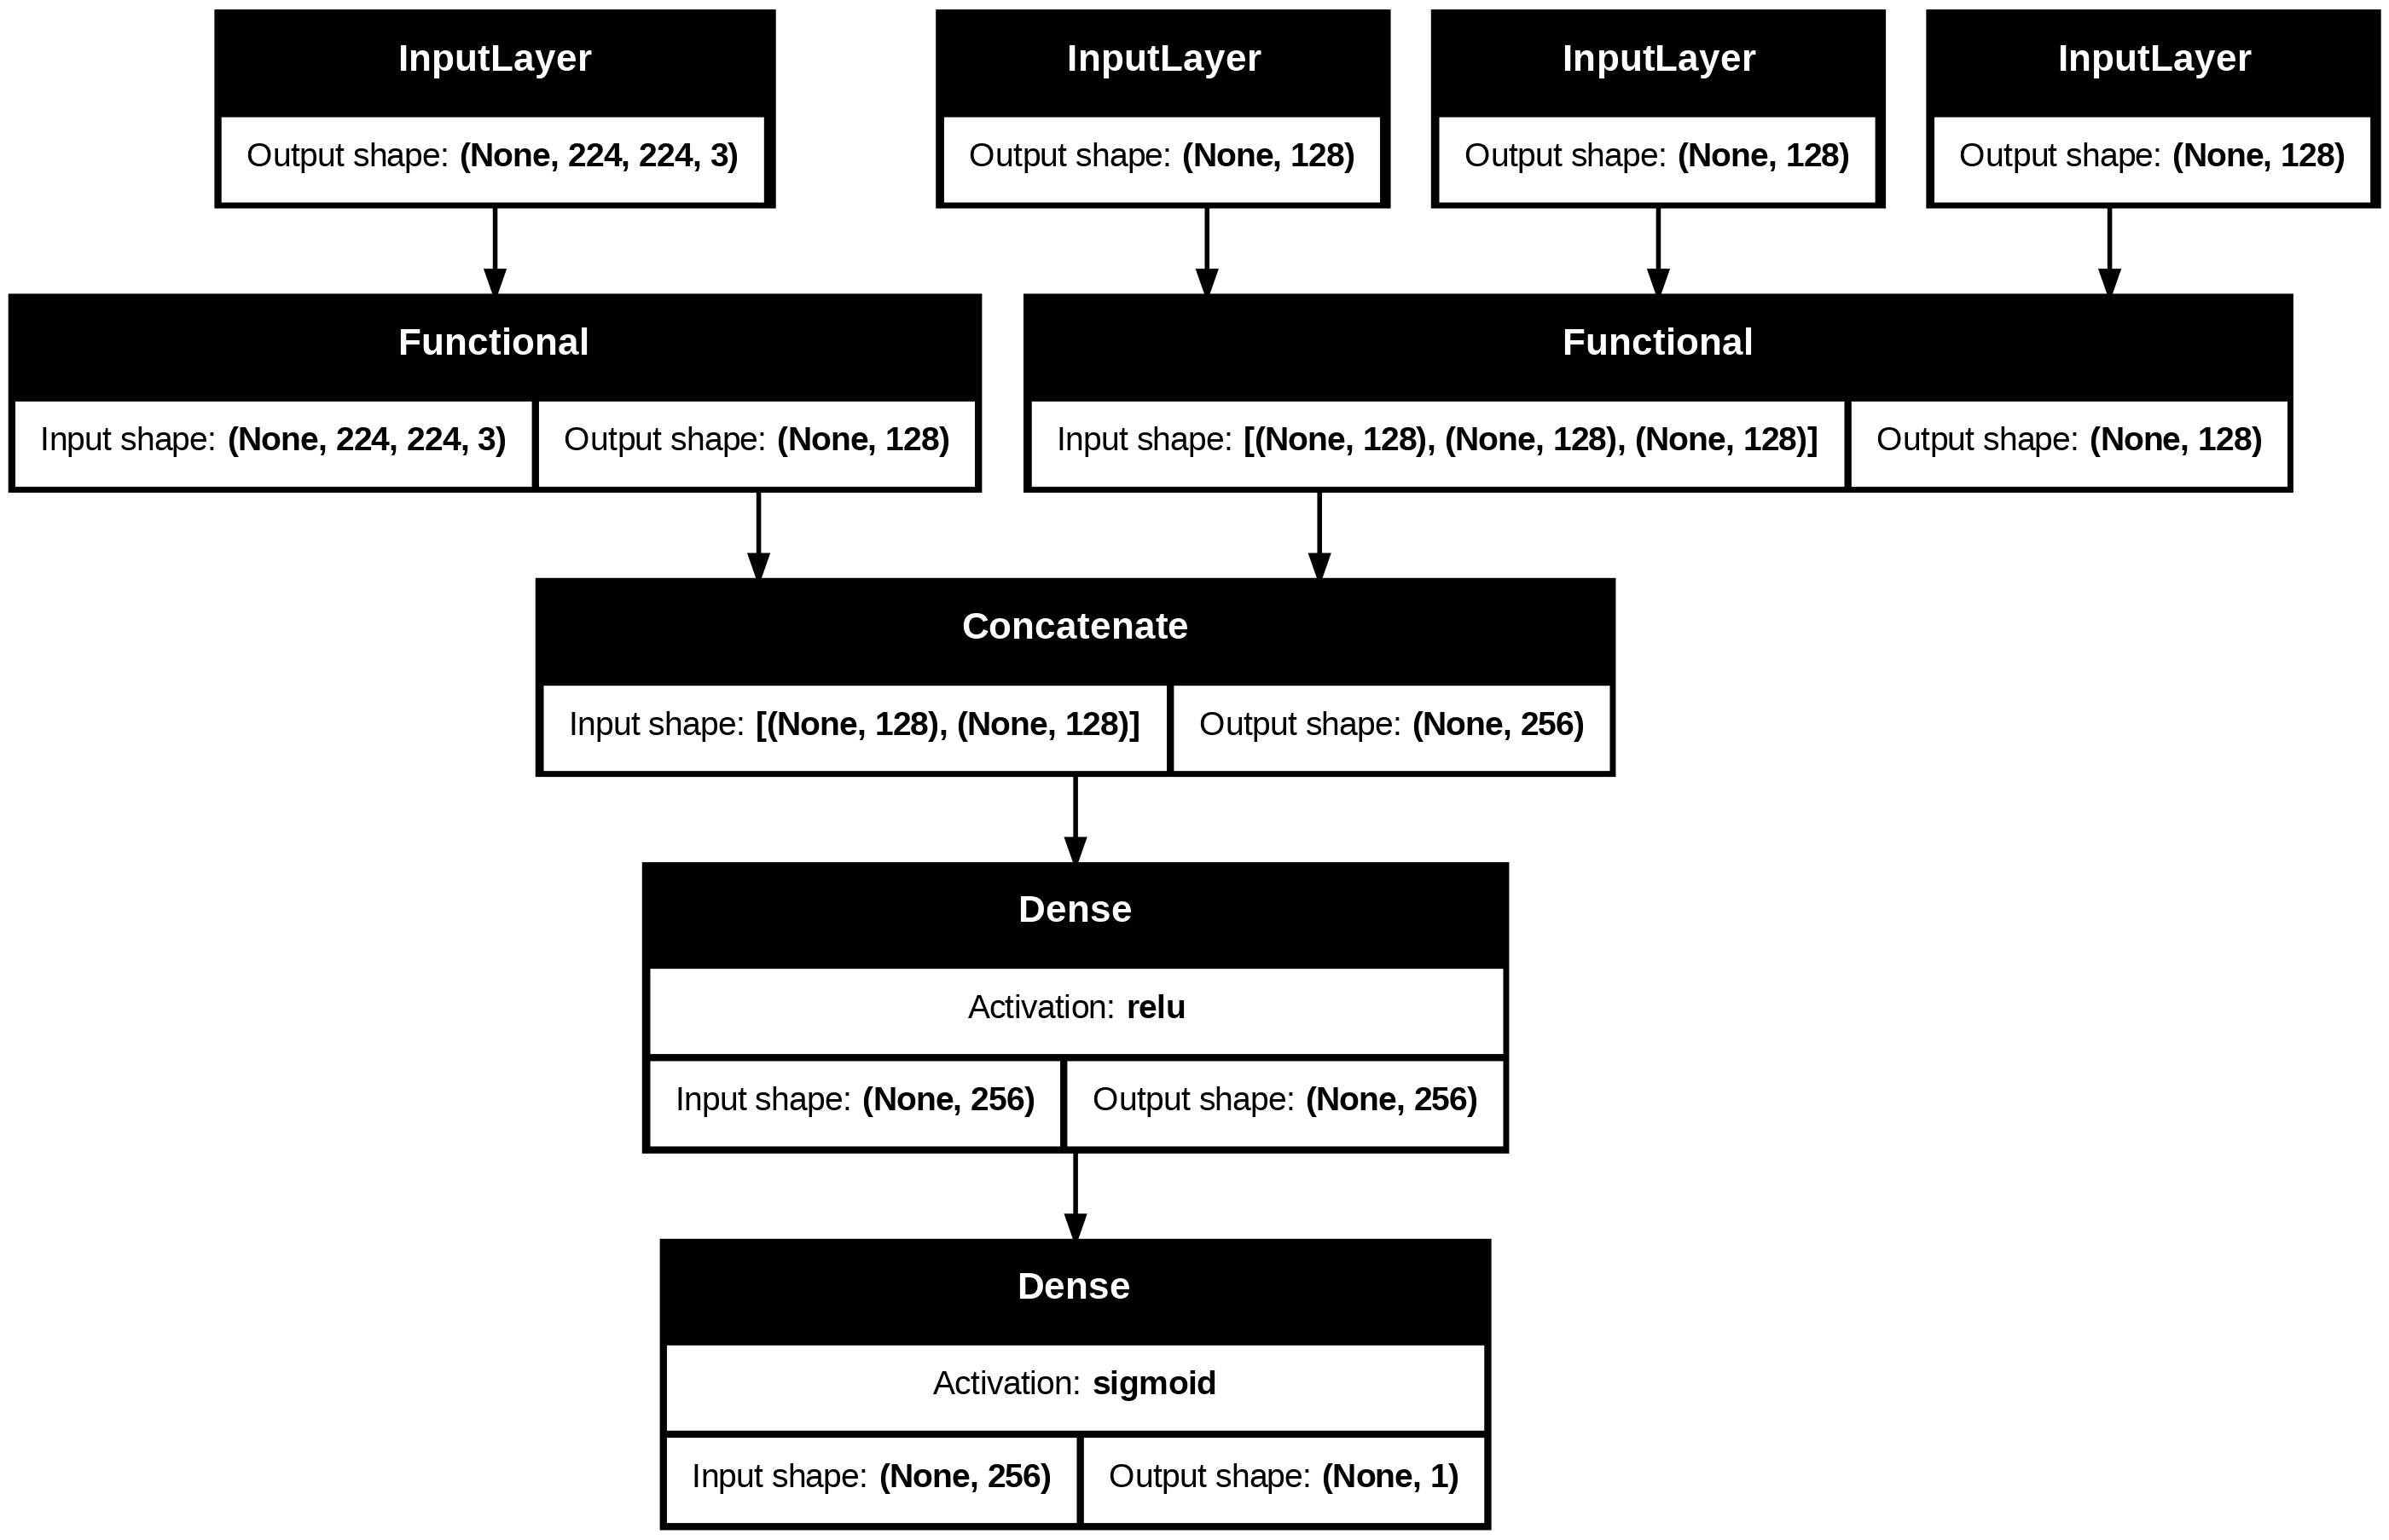

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(merge_model, to_file="/content/drive/MyDrive/binaryclass_early_fusion_model.png", show_shapes=True, show_layer_activations=True)

# Model Compile

In [ ]:
#!pip install mlflow

In [ ]:
#import mlflow.tensorflow
from tensorflow.keras.optimizers import Adam

In [ ]:
# Check out the MLflow UI as this runs
#mlflow.tensorflow.autolog(every_n_iter=2)

In [ ]:
# optimizer and metric
merge_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"]) # default lr = 0.001

In [ ]:
train_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

In [ ]:
#step_size_train = 1308//32
#step_size_valid = 437//32

In [ ]:
#step_size_train=train_data.n//train_data.batch_size
#step_size_valid=valid_generator.n//valid_generator.batch_size

In [ ]:
# Train the model
earlyfs_history = merge_model.fit(train_data,
                #steps_per_epoch=step_size_train, #tf.dataset is none
                validation_data=val_data,
                #validation_steps=step_size_valid,
                epochs=10,
                verbose=2 # show: epoch 1/10...
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  This method is designed for a special case where we want to overwrite
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 - 110s - 3s/step - accuracy: 0.5609 - loss: 0.6659 - val_accuracy: 0.9196 - val_loss: 0.4832
Epoch 2/10
40/40 - 57s - 1s/step - accuracy: 0.9215 - loss: 0.2737 - val_accuracy: 1.0000 - val_loss: 0.0695
Epoch 3/10
40/40 - 78s - 2s/step - accuracy: 0.9969 - loss: 0.0339 - val_accuracy: 0.9286 - val_loss: 0.0134
Epoch 4/10
40/40 - 52s - 1s/step - accuracy: 0.9969 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 5/10
40/40 - 83s - 2s/step - accuracy: 0.9741 - loss: 0.0128 - val_accuracy: 0.9286 - val_loss: 0.0064
Epoch 6/10
40/40 - 82s - 2s/step - accuracy: 0.9733 - loss: 0.0115 - val_accuracy: 0.9286 - val_loss: 0.0051
Epoch 7/10
40/40 - 82s - 2s/step - accuracy: 0.9977 - loss: 0.0111 - val_accuracy: 0.9286 - val_loss: 0.0042
Epoch 8/10
40/40 - 82s - 2s/step - accuracy: 0.9977 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 9/10
40/40 - 82s - 2s/step - accuracy: 0.9726 - loss: 0.0105 - val_accuracy: 0.9286 - val_loss: 0.0035
Epoch 10/10
40/40 - 82s - 2s/

In [ ]:
# Evaluate
#step_size_test = test_generator.n//test_generator.batch_size

In [ ]:
eval_results = merge_model.evaluate(test_data)
                                    #steps=step_size_test
print(f"loss: {eval_results[0]}. accuracy: {eval_results[1]}")

18/18 [==============================] - 9s 463ms/step - loss: 0.0040 - accuracy: 1.0000
loss: 0.00396938668563962. accuracy: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np

# Step 1: Generate predictions and extract true labels from test_data
y_true = []
y_pred = []

# Iterate over the test_data to get predictions and true labels
for x_batch, y_batch in test_data:
    # Predict class probabilities
    y_pred_probs = merge_model.predict(x_batch)
    y_pred_batch = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class labels (0 or 1)

    # Append predictions and true labels
    y_pred.extend(y_pred_batch.ravel())  # Use ravel() to flatten
    y_true.extend(y_batch.numpy().ravel())  # Convert tensor to numpy and flatten

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Step 3: Calculate and print F1 score
f1 = f1_score(y_true, y_pred, average="binary")  # Use 'binary' for binary classification
print(f"F1 Score: {f1:.2f}")

# Optional: Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Confusion Matrix:
[[276   0]
 [  0 300]]
F1 Score: 1.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       276
         1.0       1.00      1.00      1.00       300

    accuracy                           1.00       576
   macro 

# Plot

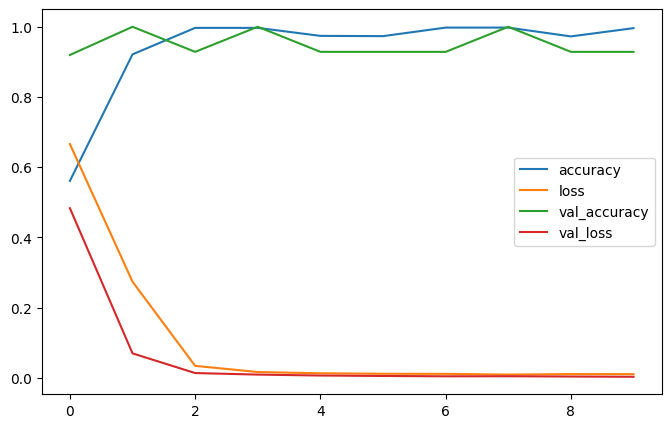

In [ ]:
pd.DataFrame(earlyfs_history.history).plot(figsize=(8,5))
plt.show()

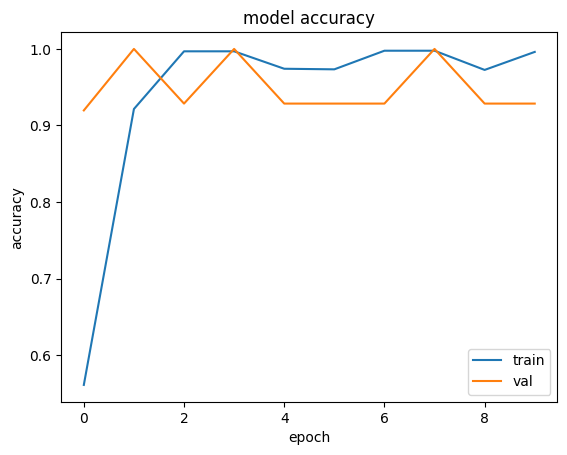

In [ ]:
# plot accuracy
plt.plot(earlyfs_history.history['accuracy'])
plt.plot(earlyfs_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

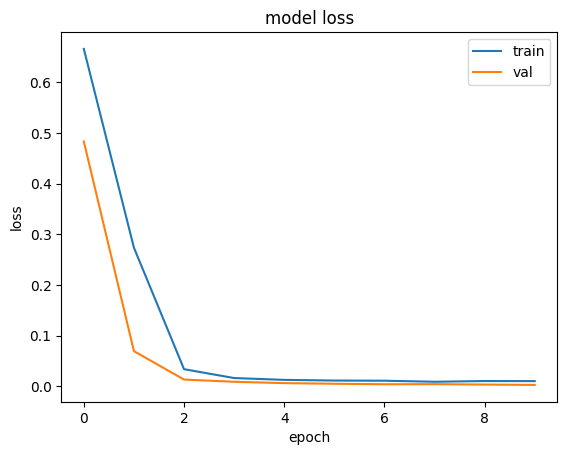

In [ ]:
# plot loss
plt.plot(earlyfs_history.history['loss'])
plt.plot(earlyfs_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()